<a href="https://colab.research.google.com/github/YUCAVALCANTE/ML_Studies/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proporção de fraude no dataset: 0.0059
Fraude no treino: 0.005893333333333334 | Fraude no teste: 0.00592
Relatório (foco na classe 1 = fraude):
              precision    recall  f1-score   support

           0     0.9975    0.9830    0.9902     12426
           1     0.1693    0.5811    0.2622        74

    accuracy                         0.9806     12500
   macro avg     0.5834    0.7821    0.6262     12500
weighted avg     0.9926    0.9806    0.9859     12500

PR-AUC (Average Precision): 0.3713


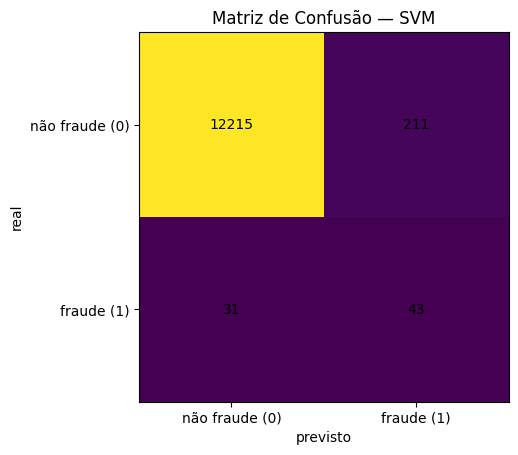

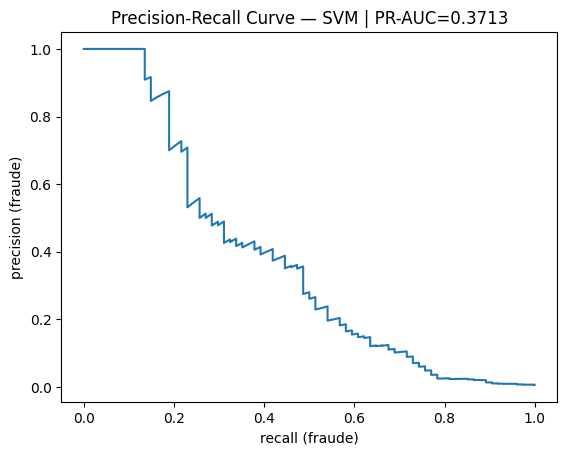

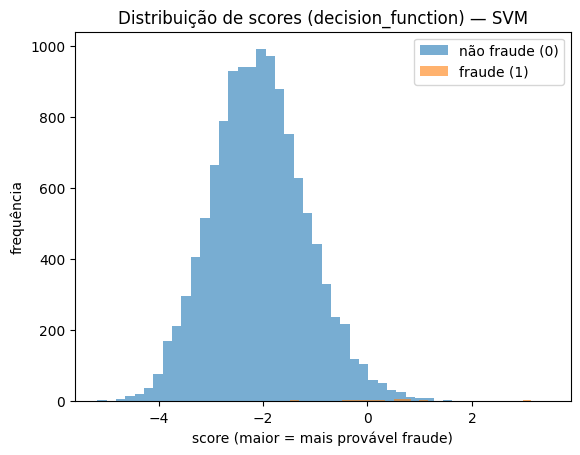

In [1]:
# O que este bloco faz:
# 1) cria uma base sintética (fraude) bem desbalanceada + faz split estratificado
# 2) treina um SVM (com pipeline e padronização) ajustado para desbalanceamento
# 3) avalia com métricas focadas na classe positiva (precision, recall, f1) e PR-AUC
# 4) plota matriz de confusão, curva precision-recall e distribuição de scores (decision_function)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)


# -----------------------------
# 0) Base — cenário desbalanceado (fraude) + split estratificado
# -----------------------------
rng = 42
np.random.seed(rng)

# Base sintética com fraude rara
X_raw, y_raw = make_classification(
    n_samples=50000,
    n_features=18,
    n_informative=6,
    n_redundant=6,
    n_repeated=0,
    n_clusters_per_class=2,
    weights=[0.995, 0.005],   # ~0.5% fraude
    class_sep=1.2,
    flip_y=0.002,
    random_state=rng
)

# Coloca em DataFrame (cara de projeto)
feature_names = [f"f_{i:02d}" for i in range(X_raw.shape[1])]
df = pd.DataFrame(X_raw, columns=feature_names)

# (Opcional) adiciona colunas com “cara” de transação
df["amount"] = np.random.lognormal(mean=3.0, sigma=1.0, size=len(df))  # valores assimétricos
df["hour"] = np.random.randint(0, 24, size=len(df))                    # hora da transação

# Target
df["fraud"] = y_raw

# X/y finais
X = df.drop(columns=["fraud"])
y = df["fraud"]

# Split estratificado (mantém proporção de fraude no treino/teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=rng
)

print("Proporção de fraude no dataset:", y.mean())
print("Fraude no treino:", y_train.mean(), "| Fraude no teste:", y_test.mean())


# -----------------------------
# 1) Modelo — SVM com escala + ajuste para desbalanceamento
# -----------------------------
svm = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", SVC(
        kernel="rbf",              # teste também "linear"
        C=1.0,
        gamma="scale",             # ou um valor numérico, ex: 0.01
        class_weight="balanced",   # importante em fraude
        probability=False,         # vamos usar decision_function (melhor para ranking)
        random_state=42
    ))
])

svm.fit(X_train, y_train)


# -----------------------------
# 2) Predição (classe) + score contínuo
# -----------------------------
y_pred = svm.predict(X_test)

# score contínuo para ranking e PR curve
# (quanto maior, mais "classe positiva")
y_score = svm.decision_function(X_test)


# -----------------------------
# 3) Métricas focadas em desbalanceamento
# -----------------------------
print("Relatório (foco na classe 1 = fraude):")
print(classification_report(y_test, y_pred, digits=4))

ap = average_precision_score(y_test, y_score)
print(f"PR-AUC (Average Precision): {ap:.4f}")


# -----------------------------
# 4) Visual 1 — Matriz de Confusão (com foco em fraude)
# -----------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Matriz de Confusão — SVM")
plt.xlabel("previsto")
plt.ylabel("real")

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

plt.xticks([0, 1], ["não fraude (0)", "fraude (1)"])
plt.yticks([0, 1], ["não fraude (0)", "fraude (1)"])
plt.show()


# -----------------------------
# 5) Visual 2 — Curva Precision-Recall
# -----------------------------
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

plt.figure()
plt.plot(recall, precision)
plt.title(f"Precision-Recall Curve — SVM | PR-AUC={ap:.4f}")
plt.xlabel("recall (fraude)")
plt.ylabel("precision (fraude)")
plt.show()


# -----------------------------
# 6) Visual 3 — Distribuição de scores por classe (decision_function)
# -----------------------------
scores_0 = y_score[y_test == 0]
scores_1 = y_score[y_test == 1]

plt.figure()
plt.hist(scores_0, bins=40, alpha=0.6, label="não fraude (0)")
plt.hist(scores_1, bins=40, alpha=0.6, label="fraude (1)")
plt.title("Distribuição de scores (decision_function) — SVM")
plt.xlabel("score (maior = mais provável fraude)")
plt.ylabel("frequência")
plt.legend()
plt.show()
